<a href="https://colab.research.google.com/github/Davydmunoz0/Boston_Housing_Pratica/blob/main/bostonhousing_davyd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Carregar dataset Boston Housing
boston = fetch_openml(name='boston', version=1, as_frame=True)
df = boston.frame.rename(columns={'MEDV': 'Preco'})

In [3]:
# Transformação logarítmica no preço
df['Preco'] = np.log1p(df['Preco'])

In [4]:
# Separar features e target
X = df.drop(columns=['Preco'])
y = df['Preco']

In [5]:
# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# Criar um ColumnTransformer para normalizar os dados
preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), X.columns)
])

In [7]:
# Criar pipeline com XGBoost
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

In [8]:
# Definir hiperparâmetros para GridSearchCV
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__max_depth': [3, 6]
}

In [9]:
# GridSearchCV para otimização de hiperparâmetros
search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', verbose=1)
search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object'))])),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [3, 6],
                         'xgb__n_estimators': [100, 200]},
             scoring='r2', verbose=1)

In [10]:
# Melhor modelo
best_model = search.best_estimator_

In [11]:
# Fazer previsões
y_pred = best_model.predict(X_test)

In [13]:
# Reverter a transformação logarítmica
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

In [14]:
# Avaliação do modelo
mse = mean_squared_error(y_test_exp, y_pred_exp)
r2 = r2_score(y_test_exp, y_pred_exp)
print(f'MSE: {mse:.2f}')
print(f'R²: {r2:.2f}')

MSE: 10.50
R²: 0.86


In [15]:
# Importância das Features
feature_importances = best_model.named_steps['xgb'].feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

<ipython-input-16-c19ae46b3ac5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


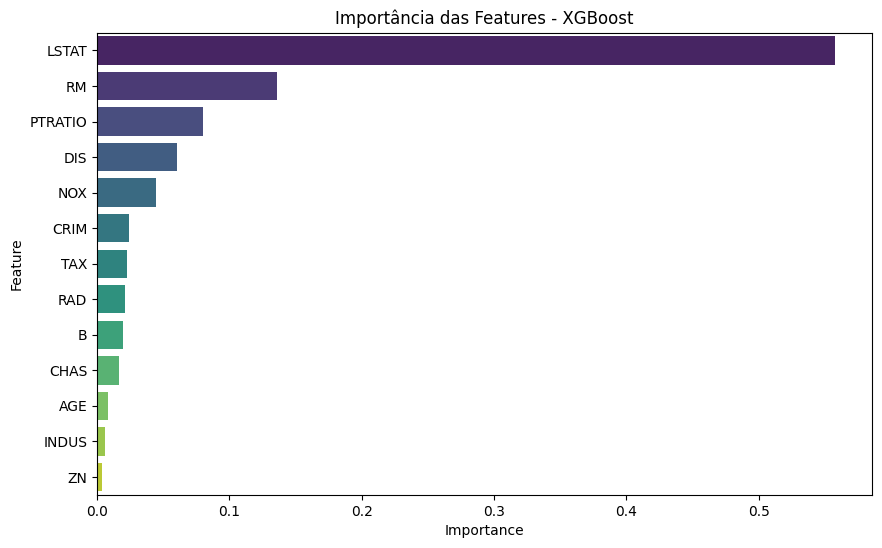

In [16]:

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Importância das Features - XGBoost')
plt.show()
